In [1]:
import numpy as np
import numba

R =  0.1
L =  0.01
struct = np.rec.array([(np.zeros((2,1)),
                        np.zeros((2,1)),
                        R,
                        L,
                        100.0,
                        )],
                       dtype=[('x', np.float64,(2,1)),
                              ('f', np.float64,(2,1)),
                              ('R', np.float64),
                              ('L', np.float64),
                              ('v', np.float64),
                             ])

In [2]:
@numba.njit(cache=True)
def f_eval(struct):
    v = struct[0].v
    L = struct[0].L
    R = struct[0].R
    i_l = struct[0].x[0,0]
    struct[0].f[0,0] =  1.0/L*(v - R*i_l)

In [19]:
@numba.njit(cache=True)
def solver(struct):
    x_0 = 0.0
    Dt = 10.0e-3
    N_steps = 1000
    T = np.zeros(N_steps)
    X = np.zeros(N_steps)
    
    t = 0.0
    struct[0].x[0,0] = x_0
    T[0] = t
    X[0] = struct[0].x[0,0]
    for it in range(N_steps-1):
        t += Dt
        f_eval(struct)
        struct[0].x[:,0] += Dt*struct[0].f[:,0]
        T[it+1] = t
        X[it+1] = struct[0].x[0,0]   
    return T,X

In [20]:
%timeit T,X = solver(struct)
T,X = solver(struct)

150 µs ± 3.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Output plot

<IPython.core.display.Javascript object>


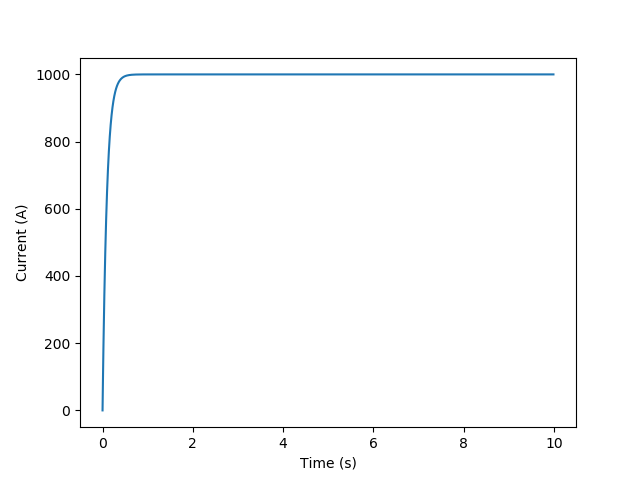

In [28]:
import matplotlib.pyplot as plt
%matplotlib notebook
#plt.style.use('')

fig, (ax0) = plt.subplots(nrows=1)   # creates a figure with one axe
ax0.plot(T,X)

ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Current (A)')
plt.show()

In [23]:
@numba.njit(cache=True)
def solver_trapz(struct):
    x_0 = 0.0
    Dt = 1.0e-3
    N_steps = 10000
    N_states = 2
    T = np.zeros(N_steps)
    X = np.zeros((N_steps,N_states))
    
    t = 0.0
    struct[0].x[0,0] = x_0
    T[0] = t
    X[0,0] = struct[0].x[0,0]
    for it in range(N_steps-1):
        t += Dt
        
        f_eval(struct)
        x_left = np.copy(struct[0].x[:,0])
        f_left = np.copy(struct[0].f[:,0])
        struct[0].x[:,0] = x_left + Dt * f_left
        f_eval(struct)
        struct[0].x[:,0] = x_left + 0.5*Dt*(f_left + struct[0].f[:,0])
        
        
        T[it+1] = t
        X[it+1,0] = struct[0].x[0,0]
        
    return T,X



In [24]:
%timeit T_trapz,X_trapz = solver_trapz(struct)
T_trapz,X_trapz = solver_trapz(struct)

3.56 ms ± 95.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:

def exact(T):
    return   1000 * (1- np.exp(-T*R/L))

<IPython.core.display.Javascript object>


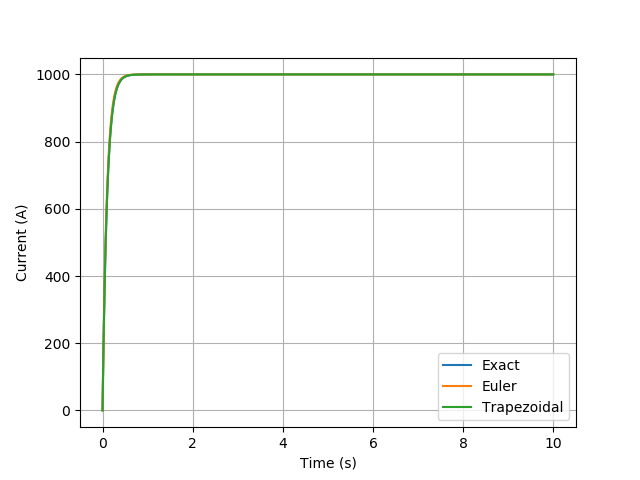

In [26]:
import matplotlib.pyplot as plt
%matplotlib notebook
#plt.style.use('')

fig, (ax0) = plt.subplots(nrows=1)   # creates a figure with one axe
ax0.plot(T_exact,X_exact, label='Exact')
ax0.plot(T,X, label='Euler')
ax0.plot(T_trapz,X_trapz[:,0], label='Trapezoidal')
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Current (A)')
ax0.grid()
ax0.legend()
plt.show()

<IPython.core.display.Javascript object>


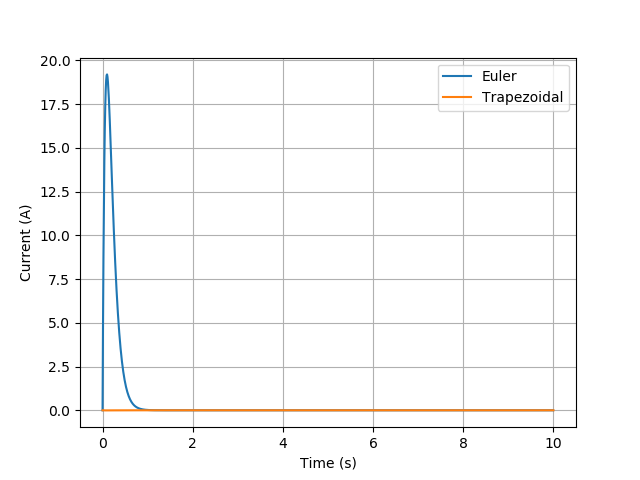

In [27]:
fig, (ax0) = plt.subplots(nrows=1)   # creates a figure with one axe

ax0.plot(T,X-exact(T), label='Euler')
ax0.plot(T_trapz,X_trapz[:,0] - exact(T_trapz), label='Trapezoidal')
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Current (A)')
ax0.grid()
ax0.legend()
plt.show()